In [1]:
!pip install sktime
!pip install sktime[all_extras]

  Using cached catch22-0.2.0-cp38-cp38-linux_x86_64.whl
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/envs/eurodatacube-0.24.5/bin/python3.8 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-r7a2ws4c/fbprophet_d421113a4fd14843a6cee8e6f34096f0/setup.py'"'"'; __file__='"'"'/tmp/pip-install-r7a2ws4c/fbprophet_d421113a4fd14843a6cee8e6f34096f0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-j4rb51dy
       cwd: /tmp/pip-install-r7a2ws4c/fbprophet_d421113a4fd14843a6cee8e6f34096f0/
  Complete output (39 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  

In [2]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [3]:
#url='https://raw.githubusercontent.com/eurodatacube/eodash/master/app/public/data/trilateral/N2.csv'
url='https://raw.githubusercontent.com/eurodatacube/eodash/master/app/public/data/trilateral/E10c.csv'

In [4]:
df = pd.read_csv(url)

In [19]:
df.Time= pd.to_datetime(df.Time, format="%Y-%m-%d")


In [29]:
italy=df[df['Country']=='US'][['Y axis','Time','Measurement Value']].dropna(subset=['Time','Measurement Value']).sort_values(by='Time',ascending=True).reset_index(drop=True)
italy.shape[0]

1083

Obs: Only Venice port in Italy
Obs: Only Chlorophyll-a concentration anomaly

In [30]:
italy

,Y axis,Time,Measurement Value
0,NDVI,2013-03-31 03:49:31,0.136119
1,NDVI,2013-03-31 03:49:54,0.136542
2,NDVI,2013-04-10 03:46:10,0.132089
3,NDVI,2013-04-17 03:47:29,0.132170
4,NDVI,2013-04-24 03:53:13,0.112326
...,...,...,...
1078,NDVI,2020-10-15 10:30:00,0.264860
1079,NDVI,2020-10-20 03:52:12,-0.054486
1080,NDVI,2020-10-23 00:00:00,0.335145
1081,NDVI,2020-10-23 10:30:00,0.212619


In [32]:
italy

,Y axis,Time,Measurement Value
0,NDVI,2013-03-31 03:49:31,0.136119
1,NDVI,2013-03-31 03:49:54,0.136542
2,NDVI,2013-04-10 03:46:10,0.132089
3,NDVI,2013-04-17 03:47:29,0.132170
4,NDVI,2013-04-24 03:53:13,0.112326
...,...,...,...
1078,NDVI,2020-10-15 10:30:00,0.264860
1079,NDVI,2020-10-20 03:52:12,-0.054486
1080,NDVI,2020-10-23 00:00:00,0.335145
1081,NDVI,2020-10-23 10:30:00,0.212619


812 271


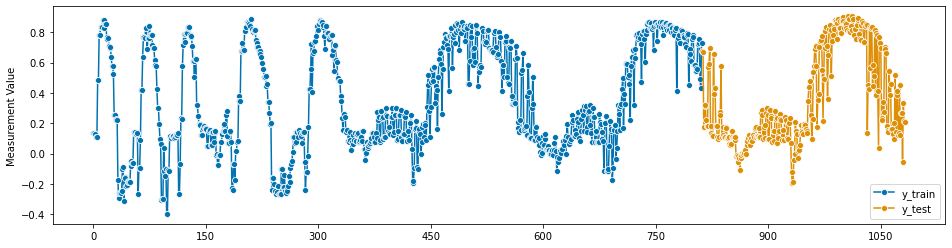

In [33]:
y_train, y_test = temporal_train_test_split(italy['Measurement Value'])
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

1.4192184076749805

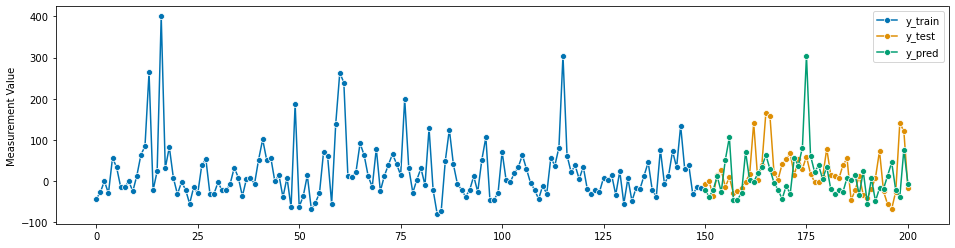

In [24]:
forecaster = NaiveForecaster(strategy="last", sp=60)
fh = np.arange(len(y_test)) + 1

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [46]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

,AOI,Country,Region,City,Site Name,Description,Method,EO Sensor,Input Data,Indicator code,...,Reference value,Rule,Indicator Value,Sub-AOI,Y axis,Indicator Name,Color code,Data Provider,AOI_ID,Update Frequency
0,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, Chl-a",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean Chl-a concentration anomaly as pro...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Chlorophyll-a concentration anomaly [%],Chlorophyll-a concentration anomaly,NaN,NASA OBPG,IT6,Weekly
1,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, Chl-a",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean Chl-a concentration anomaly as pro...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Chlorophyll-a concentration anomaly [%],Chlorophyll-a concentration anomaly,NaN,NASA OBPG,IT6,Weekly
2,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, Chl-a",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean Chl-a concentration anomaly as pro...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Chlorophyll-a concentration anomaly [%],Chlorophyll-a concentration anomaly,NaN,NASA OBPG,IT6,Weekly
3,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, Chl-a",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean Chl-a concentration anomaly as pro...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Chlorophyll-a concentration anomaly [%],Chlorophyll-a concentration anomaly,NaN,NASA OBPG,IT6,Weekly
4,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, Chl-a",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean Chl-a concentration anomaly as pro...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Chlorophyll-a concentration anomaly [%],Chlorophyll-a concentration anomaly,NaN,NASA OBPG,IT6,Weekly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, SPM",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean SPM concentration anomaly as proxy...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Total Suspended Matter concentration anomaly [%],Total Suspended Matter concentration anomaly,NaN,NASA OBPG,IT10,Weekly
1087,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, SPM",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean SPM concentration anomaly as proxy...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Total Suspended Matter concentration anomaly [%],Total Suspended Matter concentration anomaly,NaN,NASA OBPG,IT10,Weekly
1088,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, SPM",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean SPM concentration anomaly as proxy...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Total Suspended Matter concentration anomaly [%],Total Suspended Matter concentration anomaly,NaN,NASA OBPG,IT10,Weekly
1089,"45.314247, 12.508055",IT,North Adriatic Sea,"Venice, SPM",AAOT fixed station Venezia,Water Quality Time Series,Weekly mean SPM concentration anomaly as proxy...,Aqua MODIS,MODISA L2 LAC OC,N3b,...,NaN,NaN,NaN,NaN,Total Suspended Matter concentration anomaly [%],Total Suspended Matter concentration anomaly,NaN,NASA OBPG,IT10,Weekly


In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])